# pyTorch 图像识别教程


这里以 TinyMind 《汉字书法识别》比赛数据为例，展示使用 Pytorch 进行图像数据分类模型训练的整个流程。

数据地址请参考:
https://www.tinymind.cn/competitions/41#property_23

或到这里下载：
自由练习赛数据下载地址：
训练集：链接: https://pan.baidu.com/s/1UxvN7nVpa0cuY1A-0B8gjg 密码: aujd

测试集: https://pan.baidu.com/s/1tzMYlrNY4XeMadipLCPzTw 密码: 4y9k

# 数据探索
请参考官方的数据说明

# 数据处理

竞赛中只有训练集 train 数据有准确的标签，因此这里只使用 train 数据即可，实际应用中，阶段 1、2 的榜单都需要使用。

## 数据下载

下载数据之后进行解压，得到 train 文件夹，里面有 100 个文件夹，每个文件夹名字即是各个汉字的标签。类似的数据集结构经常在分类任务中见到。可以使用下述命令验证一下每个文件夹下面文件的数量，看数据集是否符合竞赛数据描述：
```sh
for l in $(ls); do echo $l $(ls $l|wc -l); done
```

## 划分数据集

因为这里只使用了 train 集，因此我们需要对已有数据集进行划分，供模型训练的时候做验证使用，也就是 validation 集的构建。
> 一般认为，train 用来训练模型，validation 用来对模型进行验证以及超参数（ hyper parameter）调整，test 用来做模型的最终验证，我们所谓模型的性能，一般也是指 test 集上模型的性能指标。但是实际项目中，一般只有 train 集，同时没有可靠的 test 集来验证模型，因此一般将 train 集划分出一部分作为 validation，同时将 validation 上的模型性能作为最终模型性能指标。

> 一般情况下，我们不严格区分 validation 和 test。

这里将每个文件夹下面随机50个文件拿出来做 validation。

```sh
export train=train
export val=validation

for d in $(ls $train); do
    mkdir -p $val/$d/
    for f in $(ls train/$d | shuf | head -n 50 ); do
        mv $train/$d/$f $val/$d/;
    done;
done
```

> 需要注意，这里的 validation 只间接通过超参数的调整参与了模型训练。因此有一定的数据浪费。

# 模型训练代码-数据部分
首先导入 pyTorch 看一下版本

In [1]:
import torch
import torchvision as tv

torch.__version__

'1.4.0'

训练模型的时候，模型内部全部都是数字，没有任何可读性，而且这些数字也需要人为给予一些实际的意义，这里将 100 个汉字作为模型输出数字的文字表述。

需要注意的是，因为模型训练往往是一个循环往复的过程，因此一个稳定的文字标签是很有必要的，这里利用相关 python 代码在首次运行的时候生成了一个标签文件，后续检测到这个标签文件，则直接调用即可。

In [2]:
import os

if os.path.exists("labels.txt"):
    with open("labels.txt") as inf:
        classes = [l.strip() for l in inf]
else:
    classes = os.listdir("worddata/train/")
    with open("labels.txt", "w") as of:
        of.write("\r\n".join(classes))

class_idx = {v: k for k, v in enumerate(classes)}
idx_class = dict(enumerate(classes))

pyTorch里面，classes有自己的组织方式，这里我们想要自定义，要做一下转换。

In [3]:
from PIL import Image

pth_classes = classes[:]
pth_classes.sort()
pth_classes_to_idx = {v: k for k, v in enumerate(pth_classes)}


def target_transform(pth_idx):
    return class_idx[pth_classes[pth_idx]]

pyTorch 中提供了直接从目录中读取数据并进行训练的 API 这里使用的API如下。

这里使用了两个数据集，分别代表 train、validation。

需要注意的是，由于 数据中，使用的图像数据集，其数值在（0， 255）之间。同时，pyTorch 用 pillow 来处理图像的加载，其图像的数据layout是（H，W，C），而 pyTorch用来训练的数据需要是（C，H，W）的，因此需要对数据做一些转换。另外，train 数据集做了一定的数据预处理（旋转、明暗度），用于进行数据增广，也做了数据打乱（shuffle），而 validation则不需要做类似的变换。

> 这里有一些地方需要注意一下，RandomRotation 我们使用了 expand 所以每次输出图像大小都不同，resize 操作要放在后面。pyTorch 中我没找到如何直接用灰度方式读取图像，对于汉字来说，色彩没有任何意义。因此这里用 Grayscale 来转换图像为灰度。ToTensor这个操作会转换数据的 layout，因此要放在最后面。

In [4]:
from multiprocessing import cpu_count

transform_train = tv.transforms.Compose(
    [
        # tv.transforms.RandomRotation((-15, 15), expand=True),
        tv.transforms.RandomRotation((-15, 15)),
        tv.transforms.Resize((128, 128)),
        tv.transforms.ColorJitter(brightness=0.5),
        tv.transforms.Grayscale(),
        tv.transforms.ToTensor(),
    ]
)
transform_val = tv.transforms.Compose(
    [
        tv.transforms.Resize((128, 128)),
        tv.transforms.Grayscale(),
        tv.transforms.ToTensor(),
    ]
)

img_gen_train = tv.datasets.ImageFolder(
    "worddata/train/", transform=transform_train, target_transform=target_transform
)


img_gen_val = tv.datasets.ImageFolder(
    "worddata/validation/", transform=transform_val, target_transform=target_transform
)

batch_size = 32

img_train = torch.utils.data.DataLoader(
    img_gen_train, batch_size=batch_size, shuffle=True, num_workers=cpu_count()
)
img_val = torch.utils.data.DataLoader(
    img_gen_val, batch_size=batch_size, num_workers=cpu_count()
)

到这里，这两个数据集就可以使用了，正式模型训练之前，我们可以先来看看这个数据集是怎么读取数据的，读取出来的数据又是设么样子的。

In [5]:
for imgs, labels in img_train:
    # img_train 只部分满足 generator 的语法，不能用 next 来获取数据
    break
imgs.shape, labels.shape

(torch.Size([32, 1, 128, 128]), torch.Size([32]))

可以看到数据是（batch, channel, height, width, height）, 因为这里是灰度图像，因此 channel 是 1。

> 需要注意，pyTorch、mxnet使用的数据 layout 与Tensorflow 不同，因此数据也有一些不同的处理方式。

把图片打印出来看看，看看数据和标签之间是否匹配


'寒'

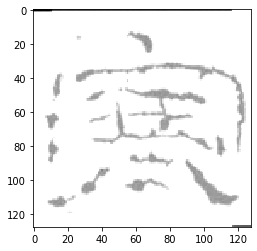

In [6]:
import numpy as np
from matplotlib import pyplot as plt

plt.imshow(imgs[0, 0, :, :], cmap="gray")
classes[labels[0]]

# 模型训练代码-模型构建

pyTorch 中使用静态图来构建模型，模型构建比较简单。这里演示的是使用 class 的方式构建模型，对于简单模型，还可以直接使用 Sequential 进行构建。

这里的复杂模型也是用 Sequential 的简单模型进行的叠加。

> 这里构建的是VGG模型，关于VGG模型的更多细节请参考 1409.1556。

In [7]:
class MyModel(torch.nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        # 模型有两个主要部分，特征提取层和分类器

        # 这里是特征提取层
        self.feature = torch.nn.Sequential()
        self.feature.add_module("conv1", self.conv(1, 64))
        self.feature.add_module("conv2", self.conv(64, 64, add_pooling=True))

        self.feature.add_module("conv3", self.conv(64, 128))
        self.feature.add_module("conv4", self.conv(128, 128, add_pooling=True))

        self.feature.add_module("conv5", self.conv(128, 256))
        self.feature.add_module("conv6", self.conv(256, 256))
        self.feature.add_module("conv7", self.conv(256, 256, add_pooling=True))

        self.feature.add_module("conv8", self.conv(256, 512))
        self.feature.add_module("conv9", self.conv(512, 512))
        self.feature.add_module("conv10", self.conv(512, 512, add_pooling=True))

        self.feature.add_module("conv11", self.conv(512, 512))
        self.feature.add_module("conv12", self.conv(512, 512))
        self.feature.add_module("conv13", self.conv(512, 512, add_pooling=True))

        self.feature.add_module("avg", torch.nn.AdaptiveAvgPool2d((1, 1)))
        self.feature.add_module("flatten", torch.nn.Flatten())

        self.feature.add_module("linear1", torch.nn.Linear(512, 4096))
        self.feature.add_module("act_linear_1", torch.nn.ReLU())
        self.feature.add_module("bn_linear_1", torch.nn.BatchNorm1d(4096))

        self.feature.add_module("linear2", torch.nn.Linear(4096, 4096))
        self.feature.add_module("act_linear_2", torch.nn.ReLU())
        self.feature.add_module("bn_linear_2", torch.nn.BatchNorm1d(4096))

        self.feature.add_module("dropout", torch.nn.Dropout())

        # 这个简单的机构是分类器
        self.pred = torch.nn.Linear(4096, 100)

    def conv(self, in_channels, out_channels, add_pooling=False):
        # 模型大量使用重复模块构建，
        # 这里将重复模块提取出来，简化模型构建过程
        model = torch.nn.Sequential()
        model.add_module(
            "conv", torch.nn.Conv2d(in_channels, out_channels, 3, padding=1)
        )
        model.add_module("act_conv", torch.nn.ReLU())
        model.add_module("bn_conv", torch.nn.BatchNorm2d(out_channels))

        if add_pooling:
            model.add_module("pool", torch.nn.MaxPool2d((2, 2)))
        return model

    def forward(self, x):
        # call 用来定义模型各个结构之间的运算关系

        x = self.feature(x)
        return self.pred(x)

可以看到，这里必须指定网络输入输出，对比 TF 和 mxnet 不是很方便。

实例化一个模型看看：

In [8]:
model = MyModel()
model

MyModel(
  (feature): Sequential(
    (conv1): Sequential(
      (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act_conv): ReLU()
      (bn_conv): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act_conv): ReLU()
      (bn_conv): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act_conv): ReLU()
      (bn_conv): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv4): Sequential(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act_conv): ReLU()
      (bn_conv): BatchNorm2d(128, e

# 模型训练代码-训练相关部分
要训练模型，我们还需要定义损失，优化器等。

In [9]:
loss_object = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())  # 优化器有些参数可以设置

In [10]:
import time  # 模型训练的过程中手动追踪一下模型的训练速度

因为模型整个训练过程一般是一个循环往复的过程，所以经常性的保存重启模型训练中间过程是有必要的。
这里我们一个ckpt保存了两份，便于中断模型的重新训练。

In [11]:
import os

gpu = 1

model.cuda(gpu)
if os.path.exists("model_ckpt.pth"):
    # 检查 checkpoint 是否存在
    # 如果存在，则加载 checkpoint

    net_state, optm_state = torch.load("model_ckpt.pth")

    model.load_state_dict(net_state)
    optimizer.load_state_dict(optm_state)

    # 这里是一个比较生硬的方式，其实还可以观察之前训练的过程，
    # 手动选择准确率最高的某次 checkpoint 进行加载。
    print("model lodaded")

In [12]:
EPOCHS = 40
for epoch in range(EPOCHS):

    train_loss = 0
    train_accuracy = 0
    train_samples = 0

    val_loss = 0
    val_accuracy = 0
    val_samples = 0

    start = time.time()
    for imgs, labels in img_train:
        imgs = imgs.cuda(gpu)
        labels = labels.cuda(gpu)

        preds = model(imgs)

        loss = loss_object(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_samples += imgs.shape[0]

        train_loss += loss.item()
        train_accuracy += (preds.argmax(dim=1) == labels).sum().item()

    train_samples_per_second = train_samples / (time.time() - start)

    start = time.time()
    for imgs, labels in img_val:
        imgs = imgs.cuda(gpu)
        labels = labels.cuda(gpu)
        model.eval()
        preds = model(imgs)
        model.train()
        val_loss += loss.item()
        val_accuracy += (preds.argmax(dim=1) == labels).sum().item()

        val_samples += imgs.shape[0]

    val_samples_per_second = val_samples / (time.time() - start)

    print(
        "Epoch {} Loss {}, Acc {}, Val Loss {}, Val Acc {}".format(
            epoch,
            train_loss * batch_size / train_samples,
            train_accuracy * 100 / train_samples,
            val_loss * batch_size / val_samples,
            val_accuracy * 100 / val_samples,
        )
    )
    print(
        "Speed train {}imgs/s val {}imgs/s".format(
            train_samples_per_second, val_samples_per_second
        )
    )

    torch.save((model.state_dict(), optimizer.state_dict()), "model_ckpt.pth")
    torch.save(
        (model.state_dict(), optimizer.state_dict()),
        "model_ckpt-{:04d}.pth".format(epoch),
    )

    # 每个 epoch 保存一下模型，需要注意每次
    # 保存要用一个不同的名字，不然会导致覆盖，
    # 同时还要关注一下磁盘空间占用，防止太多
    # chekcpoint 占满磁盘空间导致错误。

Epoch 0 Loss 6.379009783063616, Acc 0.96, Val Loss 7.499249600219726, Val Acc 1.06
Speed train 234.8145027420376imgs/s val 706.7103467600252imgs/s
Epoch 1 Loss 6.250997774396624, Acc 1.1485714285714286, Val Loss 8.049263702392578, Val Acc 1.12
Speed train 230.86756209036096imgs/s val 684.4524146021467imgs/s
Epoch 2 Loss 6.0144778276715956, Acc 1.16, Val Loss 5.387196655273438, Val Acc 1.22
Speed train 226.12469399959375imgs/s val 681.3837266883015imgs/s
Epoch 3 Loss 5.589597338867187, Acc 1.0057142857142858, Val Loss 5.907029174804688, Val Acc 1.1
Speed train 225.0556244090409imgs/s val 680.1839950846079imgs/s
Epoch 4 Loss 5.402270581054688, Acc 1.1714285714285715, Val Loss 5.1295126434326175, Val Acc 1.4
Speed train 224.72032368819234imgs/s val 682.6134263746877imgs/s
Epoch 5 Loss 5.175169513811384, Acc 1.062857142857143, Val Loss 5.386006506347656, Val Acc 0.78
Speed train 224.69030177626445imgs/s val 680.2019310561357imgs/s
Epoch 6 Loss 4.945824640328544, Acc 1.2485714285714287, Val

# 一些技巧

因为这里定义的模型比较大，同时训练的数据也比较多，每个 epoch 用时较长，因此，如果代码有 bug 的话，经过一次 epoch 再去 debug 效率比较低。

这种情况下，我们使用的数据生成过程又是自己手动指定数据数量的，因此可以尝试缩减模型规模，定义小一些的数据集来快速验证代码。在这个例子里，我们可以通过注释模型中的卷积和全连接层的代码来缩减模型尺寸，通过修改训练循环里面的数据数量来缩减数据数量。

# 训练的速度很慢
类似的网络结构和参数，TF里面 20epochs能达到90%的准确率，这里要40epochs才能到86%，应该是哪里有什么问题，我再看看怎么解决。